# Multi-Class Pneumonia Classification from Chest X-Rays

## Project Overview
This project aims to classify chest X-ray images into three categories:
1. **Normal** - Healthy lungs
2. **Bacterial Pneumonia** - Lungs affected by bacterial infection
3. **Viral Pneumonia** - Lungs affected by viral infection

In [ ]:
# Install Kaggle API
!pip3 install -q kaggle


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download the chest X-ray pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the dataset
!unzip -q chest-xray-pneumonia.zip -d ./
print("Dataset downloaded and extracted successfully!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98%|█████████████████████████████████████▍| 2.26G/2.29G [00:05<00:00, 1.03GB/s]
100%|███████████████████████████████████████| 2.29G/2.29G [00:05<00:00, 462MB/s]
Dataset downloaded and extracted successfully!


In [7]:
import shutil

# shutil.rmtree('/content/chest_xray/__MACOSX')
shutil.rmtree('chest_xray/__MACOSX')

# shutil.rmtree('/content/chest_xray/chest_xray')
shutil.rmtree('chest_xray/chest_xray')

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import random

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNet, ResNet152V2, DenseNet121
from tensorflow.keras.utils import img_to_array

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## Data Exploration

Let's examine the structure of our dataset and visualize some sample images.

In [2]:
# Define paths
BASE_PATH = './chest_xray'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VAL_PATH = os.path.join(BASE_PATH, 'val')
TEST_PATH = os.path.join(BASE_PATH, 'test')

In [3]:
def count_images_3_classes(path):
    """Count images for 3-class classification"""
    counts = {'Normal': 0, 'Bacterial Pneumonia': 0, 'Viral Pneumonia': 0}

    for category in os.listdir(path):
        category_path = os.path.join(path, category)
        if os.path.isdir(category_path):
            files = os.listdir(category_path)
            for file in files:
                if 'NORMAL' in file.upper() or category.upper() == 'NORMAL':
                    counts['Normal'] += 1
                elif 'bacteria' in file.lower():
                    counts['Bacterial Pneumonia'] += 1
                elif 'virus' in file.lower():
                    counts['Viral Pneumonia'] += 1

    return counts

train_counts = count_images_3_classes(TRAIN_PATH)
val_counts = count_images_3_classes(VAL_PATH)
test_counts = count_images_3_classes(TEST_PATH)

In [4]:
print("\nTraining Set Distribution:")
for category, count in train_counts.items():
    print(f"  {category}: {count}")
print(f"  TOTAL: {sum(train_counts.values())}")

print("\nValidation Set Distribution:")
for category, count in val_counts.items():
    print(f"  {category}: {count}")
print(f"  TOTAL: {sum(val_counts.values())}")

print("\nTest Set Distribution:")
for category, count in test_counts.items():
    print(f"  {category}: {count}")
print(f"  TOTAL: {sum(test_counts.values())}")


Training Set Distribution:
  Normal: 1341
  Bacterial Pneumonia: 2530
  Viral Pneumonia: 1345
  TOTAL: 5216

Validation Set Distribution:
  Normal: 8
  Bacterial Pneumonia: 8
  Viral Pneumonia: 0
  TOTAL: 16

Test Set Distribution:
  Normal: 234
  Bacterial Pneumonia: 242
  Viral Pneumonia: 148
  TOTAL: 624


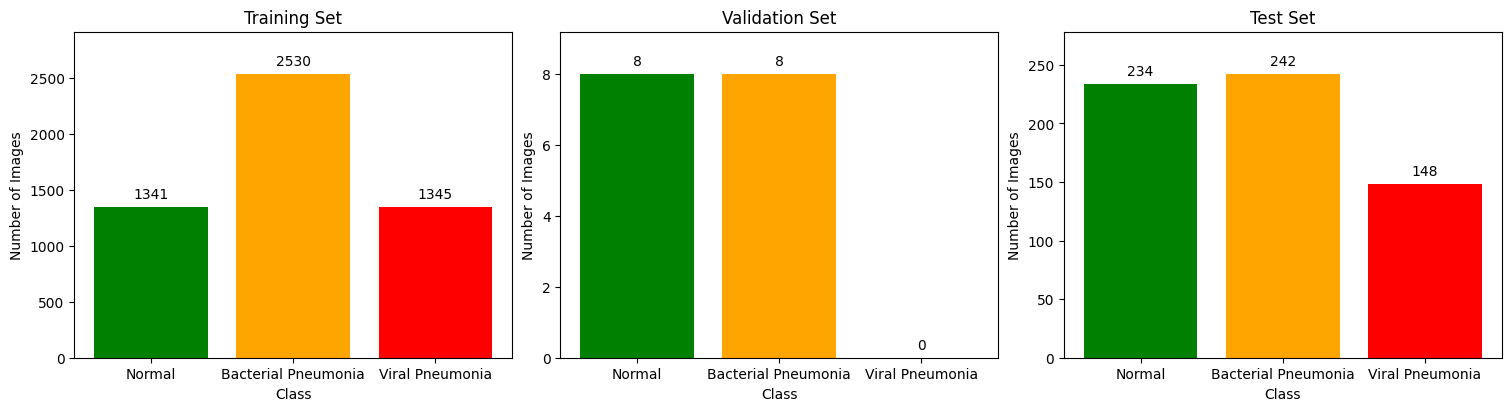

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

for idx, (title, counts) in enumerate([
    ('Training Set', train_counts),
    ('Validation Set', val_counts),
    ('Test Set', test_counts)
]):
    # Plot bars
    axes[idx].bar(counts.keys(), counts.values(), color=['green', 'orange', 'red'])

    # Titles and labels
    axes[idx].set_title(title)
    axes[idx].set_ylabel('Number of Images')
    axes[idx].set_xlabel('Class')

    for i, v in enumerate(counts.values()):
        axes[idx].text(i, v + (0.02 * max(counts.values())), str(v),
                       ha='center', va='bottom', fontsize=10)

    axes[idx].set_ylim(0, max(counts.values()) * 1.15)

plt.show()

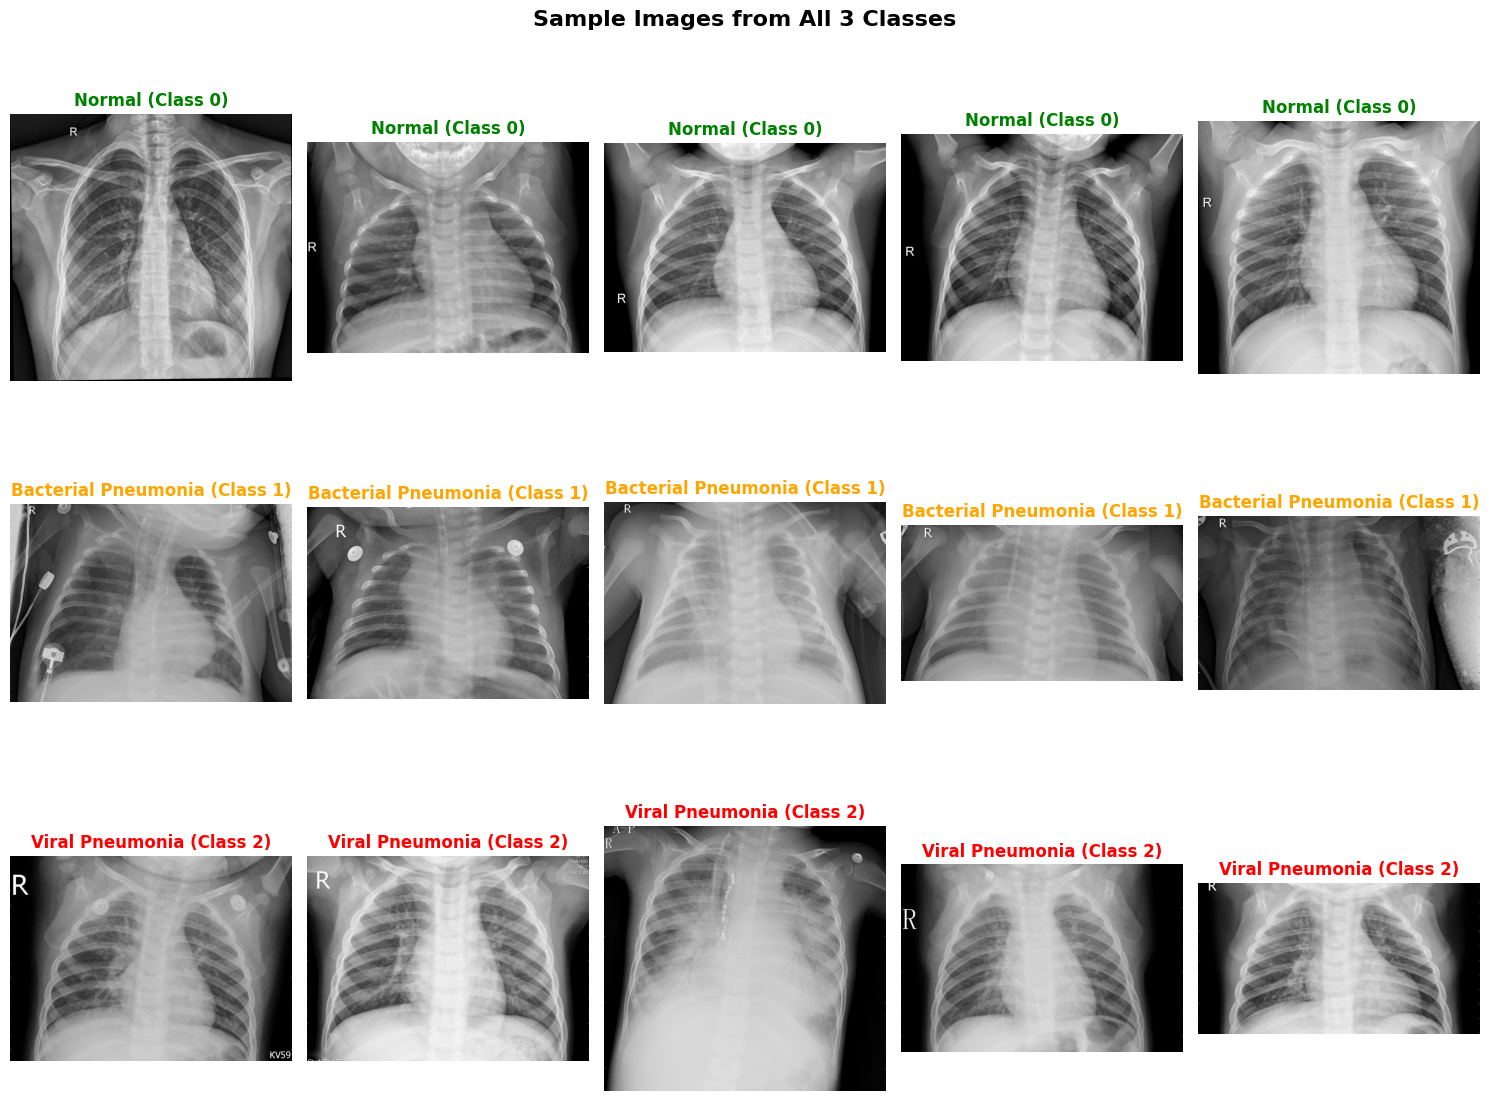

In [6]:
n_samples=5
base_path = TRAIN_PATH

fig, axes = plt.subplots(3, n_samples, figsize=(15, 12))

# Class 0: Normal
normal_path = os.path.join(base_path, 'NORMAL')
normal_files = [f for f in os.listdir(normal_path) if f.endswith(('.jpeg', '.jpg', '.png'))][:n_samples]
for j, img_file in enumerate(normal_files):
    img_path = os.path.join(normal_path, img_file)
    img = Image.open(img_path)
    axes[0, j].imshow(img, cmap='gray')
    axes[0, j].axis('off')
    axes[0, j].set_title(f'Normal (Class 0)', fontsize=12, fontweight='bold', color='green')

# Class 1: Bacterial Pneumonia
pneumonia_path = os.path.join(base_path, 'PNEUMONIA')
bacterial_files = [f for f in os.listdir(pneumonia_path) if 'bacteria' in f.lower()][:n_samples]
for j, img_file in enumerate(bacterial_files):
    img_path = os.path.join(pneumonia_path, img_file)
    img = Image.open(img_path)
    axes[1, j].imshow(img, cmap='gray')
    axes[1, j].axis('off')
    axes[1, j].set_title(f'Bacterial Pneumonia (Class 1)', fontsize=12, fontweight='bold', color='orange')

# Class 2: Viral Pneumonia
viral_files = [f for f in os.listdir(pneumonia_path) if 'virus' in f.lower()][:n_samples]
for j, img_file in enumerate(viral_files):
    img_path = os.path.join(pneumonia_path, img_file)
    img = Image.open(img_path)
    axes[2, j].imshow(img, cmap='gray')
    axes[2, j].axis('off')
    axes[2, j].set_title(f'Viral Pneumonia (Class 2)', fontsize=12, fontweight='bold', color='red')

plt.suptitle('Sample Images from All 3 Classes', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Data Preprocessing

- We'll resize images to a standard size and apply padding to maintain aspect ratio.
- We'll also normalize pixel values to [0, 1] range.

In [7]:
def resize_with_padding(image, target_size):
    """Resize image while maintaining aspect ratio with padding"""
    img_ratio = image.width / image.height
    target_ratio = target_size[0] / target_size[1]

    if img_ratio > target_ratio:
        new_width = target_size[0]
        new_height = round(new_width / img_ratio)
    else:
        new_height = target_size[1]
        new_width = round(new_height * img_ratio)

    img_resized = image.resize((new_width, new_height), Image.LANCZOS)

    new_image = Image.new("RGB", target_size, (0, 0, 0))
    new_image.paste(img_resized, ((target_size[0] - new_width) // 2,
                                   (target_size[1] - new_height) // 2))

    return new_image

In [8]:
def resize_dataset(input_dir, output_dir, size=224):
    """Resize all images in dataset"""
    target_size = (size, size)

    for root, _, files in os.walk(input_dir):
        for file in tqdm(files, desc=f"Resizing images in {os.path.basename(root)}"):
            if file.endswith(('.jpeg', '.jpg', '.png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path)

                img_resized = resize_with_padding(img, target_size)

                # Create output path maintaining directory structure
                rel_path = os.path.relpath(root, input_dir)
                output_path_dir = os.path.join(output_dir, rel_path)
                os.makedirs(output_path_dir, exist_ok=True)

                output_path = os.path.join(output_path_dir, file)
                img_resized.save(output_path)

In [9]:
IMG_SIZE = 224
RESIZED_PATH = f'./chest_xray_resized_{IMG_SIZE}'

if not os.path.exists(RESIZED_PATH):
    print(f"Resizing images to {IMG_SIZE}x{IMG_SIZE}...")
    resize_dataset(BASE_PATH, RESIZED_PATH, size=IMG_SIZE)
    print("Resizing complete!")
else:
    print(f"Resized images already exist at {RESIZED_PATH}")

# Update paths
TRAIN_PATH_RESIZED = os.path.join(RESIZED_PATH, 'train')
VAL_PATH_RESIZED = os.path.join(RESIZED_PATH, 'val')
TEST_PATH_RESIZED = os.path.join(RESIZED_PATH, 'test')

Resizing images to 224x224...


Resizing images in chest_xray: 0it [00:00, ?it/s]
Resizing images in test: 0it [00:00, ?it/s]
Resizing images in NORMAL: 100%|██████████| 234/234 [00:01<00:00, 123.96it/s]
Resizing images in train: 0it [00:00, ?it/s]
Resizing images in NORMAL: 100%|██████████| 1341/1341 [00:15<00:00, 85.54it/s] 
Resizing images in val: 0it [00:00, ?it/s]
Resizing images in NORMAL: 100%|██████████| 8/8 [00:00<00:00, 136.47it/s]

Resizing complete!


In [10]:
def load_images_and_labels_3_classes(input_dir, img_size=224, rgb=True):
    """
    Load images and create labels for 3-CLASS classification
    """
    images = []
    labels = []

    print(f"\nLoading images from: {input_dir}")
    print(f"Target classes: 0=Normal, 1=Bacterial Pneumonia, 2=Viral Pneumonia")

    # Process all subdirectories
    for root, dirs, files in os.walk(input_dir):
        for file in tqdm(files, desc=f"Loading from {os.path.basename(root)}"):
            if not file.endswith(('.jpeg', '.jpg', '.png')):
                continue

            img_path = os.path.join(root, file)

            try:
                if rgb:
                    img = Image.open(img_path).convert('RGB')
                else:
                    img = Image.open(img_path).convert('L')

                img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
                images.append(img_array)

                # Assign labels based on filename
                # Class 0: Normal
                if 'NORMAL' in file.upper() or 'NORMAL' in root.upper():
                    labels.append(0)
                # Class 1: Bacterial Pneumonia
                elif 'bacteria' in file.lower():
                    labels.append(1)
                # Class 2: Viral Pneumonia
                elif 'virus' in file.lower():
                    labels.append(2)
                else:
                    if 'PNEUMONIA' in root.upper():
                        labels.append(1)
                    else:
                        continue

            except Exception as e:
                print(f"Error loading {file}: {e}")
                continue

    X = np.array(images)
    y = np.array(labels)

    # Display statistics
    print(f"Dataset Loading Summary:")
    print(f"Total images loaded: {len(X)}")
    print(f"Image shape: {X[0].shape}")
    print(f"\nClass Distribution:")
    unique, counts = np.unique(y, return_counts=True)
    class_names_temp = ['Normal', 'Bacterial Pneumonia', 'Viral Pneumonia']
    for cls, cnt in zip(unique, counts):
        print(f"  Class {cls} ({class_names_temp[cls]}): {cnt} images ({cnt/len(y)*100:.1f}%)")

    return X, y

In [11]:
# Load training data (3 classes)
print("Loading Training Data - 3 Classes")
X_train_full, y_train_full = load_images_and_labels_3_classes(
    TRAIN_PATH_RESIZED,
    img_size=IMG_SIZE,
    rgb=True
)

Loading Training Data - 3 Classes

Loading images from: ./chest_xray_resized_224/train
Target classes: 0=Normal, 1=Bacterial Pneumonia, 2=Viral Pneumonia


Loading from train: 0it [00:00, ?it/s]
Loading from NORMAL: 100%|██████████| 1341/1341 [00:00<00:00, 1837.49it/s]


Dataset Loading Summary:
Total images loaded: 5216
Image shape: (224, 224, 3)

Class Distribution:
  Class 0 (Normal): 1341 images (25.7%)
  Class 1 (Bacterial Pneumonia): 2530 images (48.5%)
  Class 2 (Viral Pneumonia): 1345 images (25.8%)


In [12]:
# Load test data (3 classes)
print("Loading Test Data - 3 Classes")
X_test, y_test = load_images_and_labels_3_classes(
    TEST_PATH_RESIZED,
    img_size=IMG_SIZE,
    rgb=True
)

Loading Test Data - 3 Classes

Loading images from: ./chest_xray_resized_224/test
Target classes: 0=Normal, 1=Bacterial Pneumonia, 2=Viral Pneumonia


Loading from test: 0it [00:00, ?it/s]
Loading from NORMAL: 100%|██████████| 234/234 [00:00<00:00, 1970.96it/s]


Dataset Loading Summary:
Total images loaded: 624
Image shape: (224, 224, 3)

Class Distribution:
  Class 0 (Normal): 234 images (37.5%)
  Class 1 (Bacterial Pneumonia): 242 images (38.8%)
  Class 2 (Viral Pneumonia): 148 images (23.7%)


#### The original validation set has 0 viral pneumonia cases! We'll create our own validation set from training data This makes it unsuitable for 3-class classification training.
- We'll split the training data to create a proper validation set that includes all 3 classes with stratified sampling.

In [13]:
# Split training data to create validation set (stratified to maintain class balance)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15,  # Use 15% for validation (~782 images)
    random_state=42,
    stratify=y_train_full  # Maintain class distribution
)

In [14]:
print("Final Dataset Split Summary - 3 Classes")

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

Final Dataset Split Summary - 3 Classes
Training set: 4433 images
Validation set: 783 images
Test set: 624 images


In [15]:
for name, y_data in [('Training', y_train), ('Validation', y_val), ('Test', y_test)]:
    print(f"\n{name} Set Class Distribution:")
    unique, counts = np.unique(y_data, return_counts=True)
    class_names_temp = ['Normal', 'Bacterial Pneumonia', 'Viral Pneumonia']
    total = len(y_data)
    for cls, cnt in zip(unique, counts):
        print(f"  Class {cls} ({class_names_temp[cls]:20s}): {cnt:4d} images ({cnt/total*100:5.1f}%)")
    print(f"  {'TOTAL':27s}: {total:4d} images")


Training Set Class Distribution:
  Class 0 (Normal              ): 1140 images ( 25.7%)
  Class 1 (Bacterial Pneumonia ): 2150 images ( 48.5%)
  Class 2 (Viral Pneumonia     ): 1143 images ( 25.8%)
  TOTAL                      : 4433 images

Validation Set Class Distribution:
  Class 0 (Normal              ):  201 images ( 25.7%)
  Class 1 (Bacterial Pneumonia ):  380 images ( 48.5%)
  Class 2 (Viral Pneumonia     ):  202 images ( 25.8%)
  TOTAL                      :  783 images

Test Set Class Distribution:
  Class 0 (Normal              ):  234 images ( 37.5%)
  Class 1 (Bacterial Pneumonia ):  242 images ( 38.8%)
  Class 2 (Viral Pneumonia     ):  148 images ( 23.7%)
  TOTAL                      :  624 images


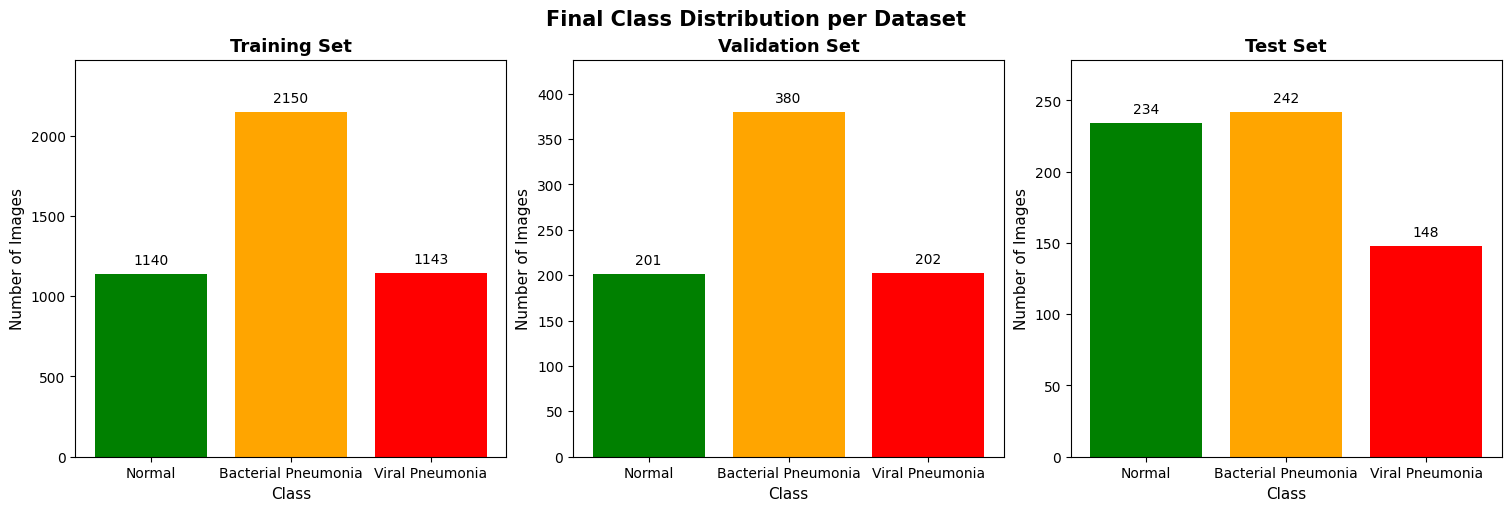

In [16]:
class_names = ['Normal', 'Bacterial Pneumonia', 'Viral Pneumonia']

# Calculate distributions
datasets = {
    'Training': y_train,
    'Validation': y_val,
    'Test': y_test
}

distributions = {}
for name, y_data in datasets.items():
    unique, counts = np.unique(y_data, return_counts=True)
    counts_dict = dict(zip(unique, counts))
    distributions[name] = [counts_dict.get(i, 0) for i in range(3)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

colors = ['green', 'orange', 'red']

for idx, (name, counts) in enumerate(distributions.items()):
    bars = axes[idx].bar(class_names, counts, color=colors)
    axes[idx].set_title(f"{name} Set", fontsize=13, weight='bold')
    axes[idx].set_xlabel("Class", fontsize=11)
    axes[idx].set_ylabel("Number of Images", fontsize=11)
    axes[idx].set_ylim(0, max(counts) * 1.15)

    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2, height + (0.02 * max(counts)),
                       str(int(height)), ha='center', va='bottom', fontsize=10)

fig.suptitle("Final Class Distribution per Dataset", fontsize=15, weight='bold')

plt.show()

## Data Augmentation

To improve model generalization and handle class imbalance, we'll apply data augmentation techniques.

In [17]:
# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator()

In [18]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=32)

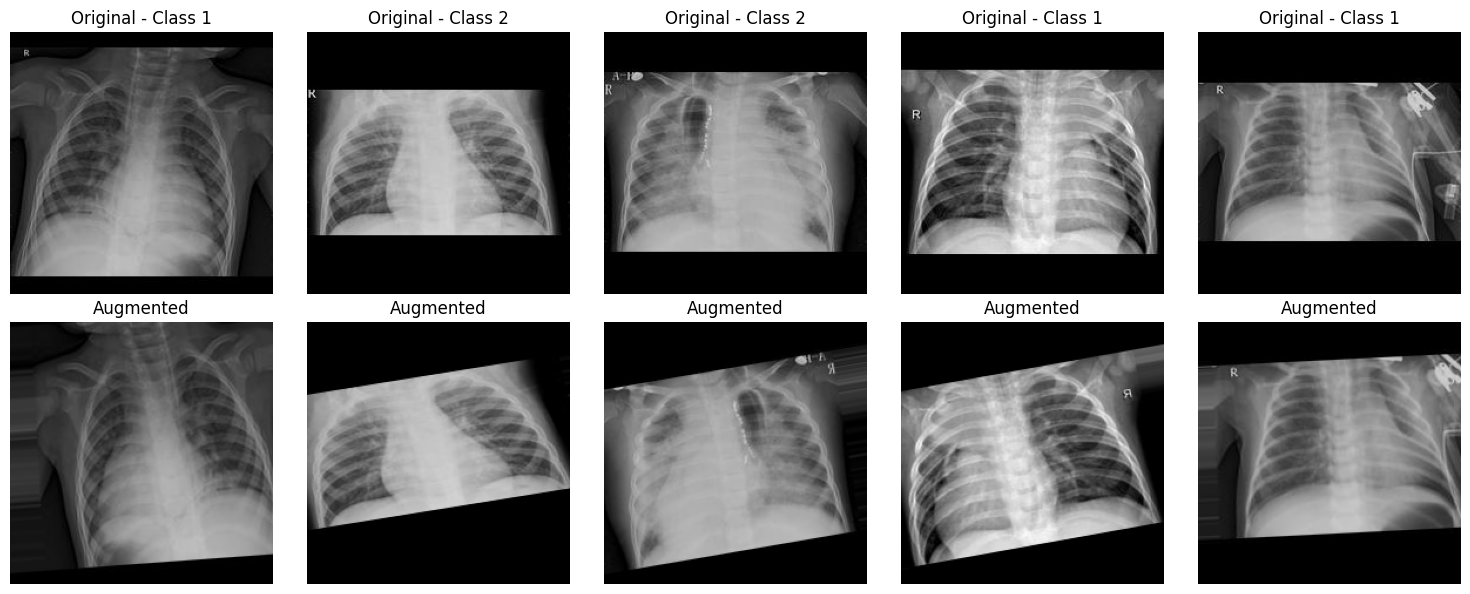

In [19]:
n_images=5

fig, axes = plt.subplots(2, n_images, figsize=(15, 6))

# Select random images
indices = random.sample(range(len(X_train)), n_images)

for i, idx in enumerate(indices):
    # Original image
    axes[0, i].imshow(X_train[idx])
    axes[0, i].set_title(f'Original - Class {y_train[idx]}')
    axes[0, i].axis('off')

    # Augmented image
    img_aug = next(train_datagen.flow(X_train[idx:idx+1], batch_size=1))[0]
    axes[1, i].imshow(img_aug)
    axes[1, i].set_title('Augmented')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Model Building

In [ ]:
# CNN model
model_cnn = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(3, activation='softmax')
])


In [40]:
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 111, 111, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 54, 54, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,562,339 (21.22 MB)

 Trainable params: 5,562,115 (21.22 MB)

 Non-trainable params: 224 (896.00 B)

In [41]:
print("Training Custom CNN Model...")

history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

print("Training complete!")

Training Custom CNN Model...
Epoch 1/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 46s 317ms/step - accuracy: 0.6503 - loss: 1.8032 - val_accuracy: 0.4342 - val_loss: 2.7378
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 47s 336ms/step - accuracy: 0.6743 - loss: 1.1063 - val_accuracy: 0.5019 - val_loss: 1.8843
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 44s 314ms/step - accuracy: 0.7081 - loss: 0.9649 - val_accuracy: 0.7088 - val_loss: 0.9756
Epoch 4/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 49s 349ms/step - accuracy: 0.7309 - loss: 0.9194 - val_accuracy: 0.7063 - val_loss: 0.9582
Epoch 5/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 51s 366ms/step - accuracy: 0.7406 - loss: 0.8822 - val_accuracy: 0.7791 - val_loss: 0.8323
Epoch 6/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 47s 335ms/step - accuracy: 0.7494 - loss: 0.8288 - val_accuracy: 0.6960 - val_loss: 1.0983
Epoch 7/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 49s 350ms/step - accuracy: 0.7498 - loss: 0.8486 - val_accuracy: 0.7063 - val_loss: 0.9506
Epoch 8/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 51s 363ms/step

In [42]:
def plot_training_history(history, title='Model Training History'):
    """Plot training and validation accuracy/loss"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title(f'{title} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title(f'{title} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

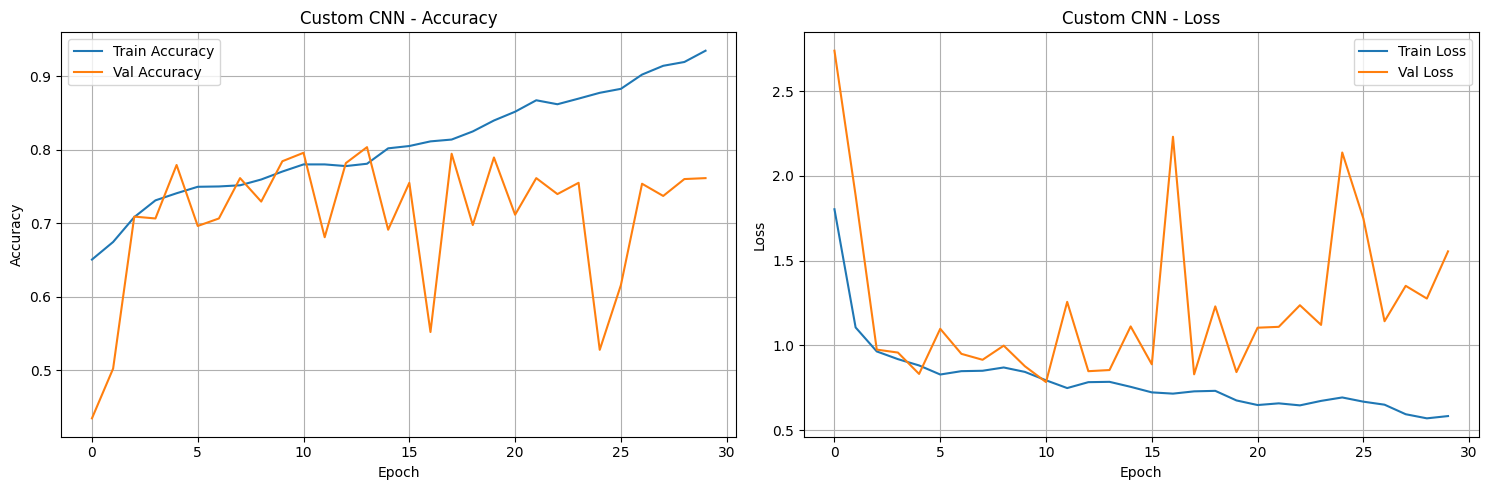

In [43]:
plot_training_history(history_cnn, 'Custom CNN')

In [44]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model, X_test, y_test, class_names=['Normal', 'Bacterial Pneumonia', 'Viral Pneumonia']):
    # Evaluate test performance
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f" Test Loss: {test_loss:.4f}")

    # Make predictions
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification report
    print("Classification Report")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Per-class accuracy
    print("\nPer-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = y_test == i
        if np.sum(class_mask) > 0:
            class_acc = accuracy_score(y_test[class_mask], y_pred[class_mask])
            print(f"  {class_name} (Class {i}): {class_acc:.4f} ({class_acc*100:.1f}%)")

    # Prediction distribution
    print("\nPrediction Distribution:")
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    for cls, cnt in zip(unique_pred, counts_pred):
        print(f"  Predicted as {class_names[cls]}: {cnt} images ({cnt/len(y_pred)*100:.1f}%)")

    return y_pred, y_pred_probs

In [45]:
y_pred, y_pred_probs = evaluate_model(model_cnn, X_test, y_test)


 Test Accuracy: 0.5721 (57.21%)
 Test Loss: 2.2292
Classification Report
                     precision    recall  f1-score   support

             Normal       0.97      0.36      0.52       234
Bacterial Pneumonia       0.54      0.95      0.69       242
    Viral Pneumonia       0.38      0.29      0.33       148

           accuracy                           0.57       624
          macro avg       0.63      0.53      0.51       624
       weighted avg       0.66      0.57      0.54       624


Per-Class Accuracy:
  Normal (Class 0): 0.3590 (35.9%)
  Bacterial Pneumonia (Class 1): 0.9504 (95.0%)
  Viral Pneumonia (Class 2): 0.2905 (29.1%)

Prediction Distribution:
  Predicted as Normal: 87 images (13.9%)
  Predicted as Bacterial Pneumonia: 424 images (67.9%)
  Predicted as Viral Pneumonia: 113 images (18.1%)


In [46]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix for 3-class classification"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - 3-Class Classification\n(Normal, Bacterial, Viral)',
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    # Add text showing total for each class
    for i in range(len(class_names)):
        row_total = np.sum(cm[i, :])
        plt.text(len(class_names) + 0.5, i + 0.5, f'n={row_total}',
                ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    print("\nConfusion Matrix:")
    print(cm)

    print("\nDetailed Breakdown:")
    for i, true_class in enumerate(class_names):
        for j, pred_class in enumerate(class_names):
            count = cm[i, j]
            if count > 0:
                percentage = (count / np.sum(cm[i, :])) * 100
                status = " Correct" if i == j else " Misclassified"
                print(f"  {status}: {true_class} → {pred_class}: {count} ({percentage:.1f}%)")
    return cm

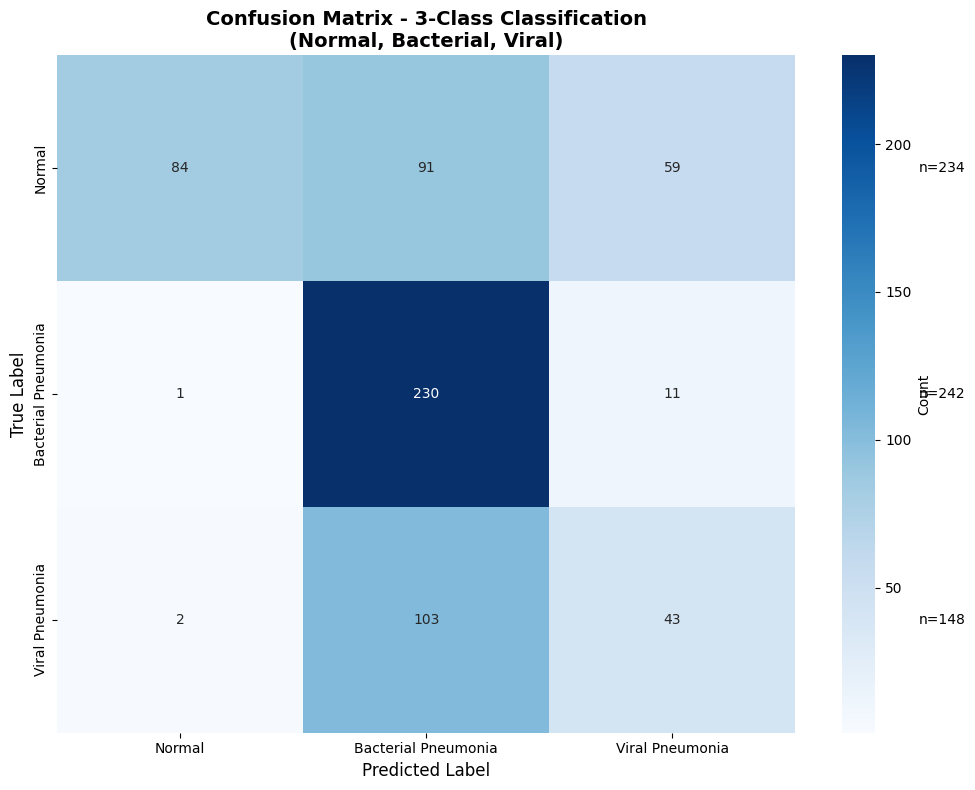


Confusion Matrix:
[[ 84  91  59]
 [  1 230  11]
 [  2 103  43]]

Detailed Breakdown:
   Correct: Normal → Normal: 84 (35.9%)
   Misclassified: Normal → Bacterial Pneumonia: 91 (38.9%)
   Misclassified: Normal → Viral Pneumonia: 59 (25.2%)
   Misclassified: Bacterial Pneumonia → Normal: 1 (0.4%)
   Correct: Bacterial Pneumonia → Bacterial Pneumonia: 230 (95.0%)
   Misclassified: Bacterial Pneumonia → Viral Pneumonia: 11 (4.5%)
   Misclassified: Viral Pneumonia → Normal: 2 (1.4%)
   Misclassified: Viral Pneumonia → Bacterial Pneumonia: 103 (69.6%)
   Correct: Viral Pneumonia → Viral Pneumonia: 43 (29.1%)


In [47]:
cm_cnn = plot_confusion_matrix(y_test, y_pred, class_names)

In [48]:
def plot_roc_curves(y_true, y_pred_probs, class_names):
    """Plot ROC curves for multi-class classification"""
    n_classes = len(class_names)

    # Binarize labels
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Overall AUC
    overall_auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
    print(f"\nOverall AUC-ROC Score: {overall_auc:.4f}")

    return roc_auc

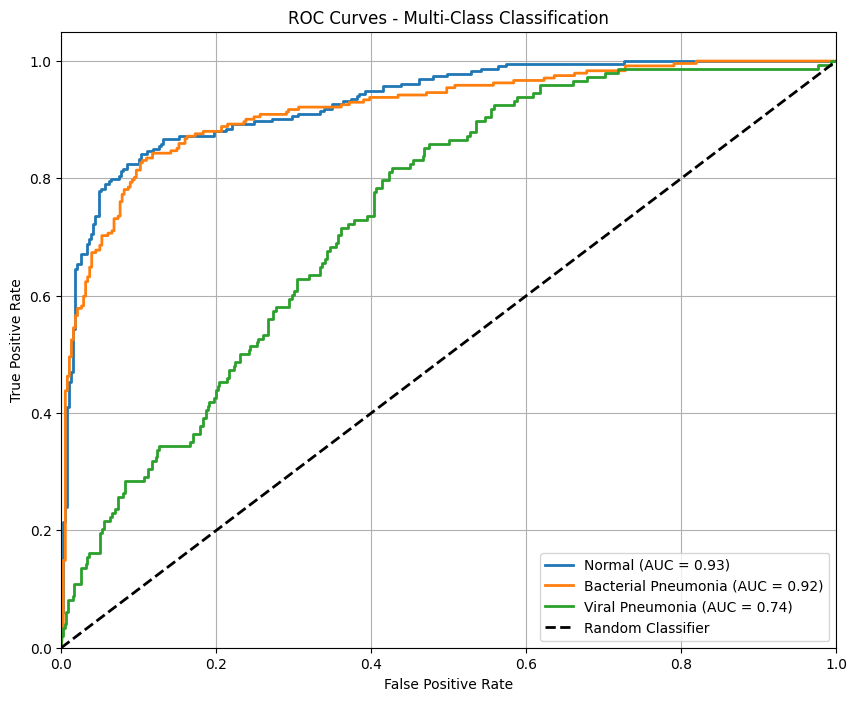


Overall AUC-ROC Score: 0.8627


In [49]:
roc_auc_cnn = plot_roc_curves(y_test, y_pred_probs, class_names)

## Optimization with Callbacks:

1. **EarlyStopping** – stops training when validation loss doesn't improve for 5 epochs.
2. **ReduceLROnPlateau** – reduces learning rate if validation loss plateaus.
3. **ModelCheckpoint** – saves the best model based on validation loss.

In [50]:
model_cnn_optimized = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),

    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(3, activation='softmax')
])

/Users/nagavenkatasaimaheshandey/Desktop/kaggle_project/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
model_cnn_optimized.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn_optimized.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,331,267 (73.74 MB)

 Trainable params: 19,330,307 (73.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [52]:
# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='min',
    verbose=1,
    min_lr=1e-7
)

checkpoint = ModelCheckpoint(
    'best_custom_cnn.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

In [53]:
history_cnn_optmized = model_cnn_optimized.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5366 - loss: 6.6765
Epoch 1: val_loss improved from None to 4.10729, saving model to best_custom_cnn.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.5730 - loss: 5.2966 - val_accuracy: 0.4853 - val_loss: 4.1073 - learning_rate: 0.0010
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6115 - loss: 3.2747
Epoch 2: val_loss improved from 4.10729 to 3.57238, saving model to best_custom_cnn.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6413 - loss: 3.0227 - val_accuracy: 0.4853 - val_loss: 3.5724 - learning_rate: 0.0010
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6698 - loss: 2.5277
Epoch 3: val_loss improved from 3.57238 to 2.20929, saving model to best_custom_cnn.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.6907 - loss: 2.3957 - val_accuracy: 0.6731 - val_loss: 2.2093 - learning_rate: 0.0010
Epoch 4/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step -

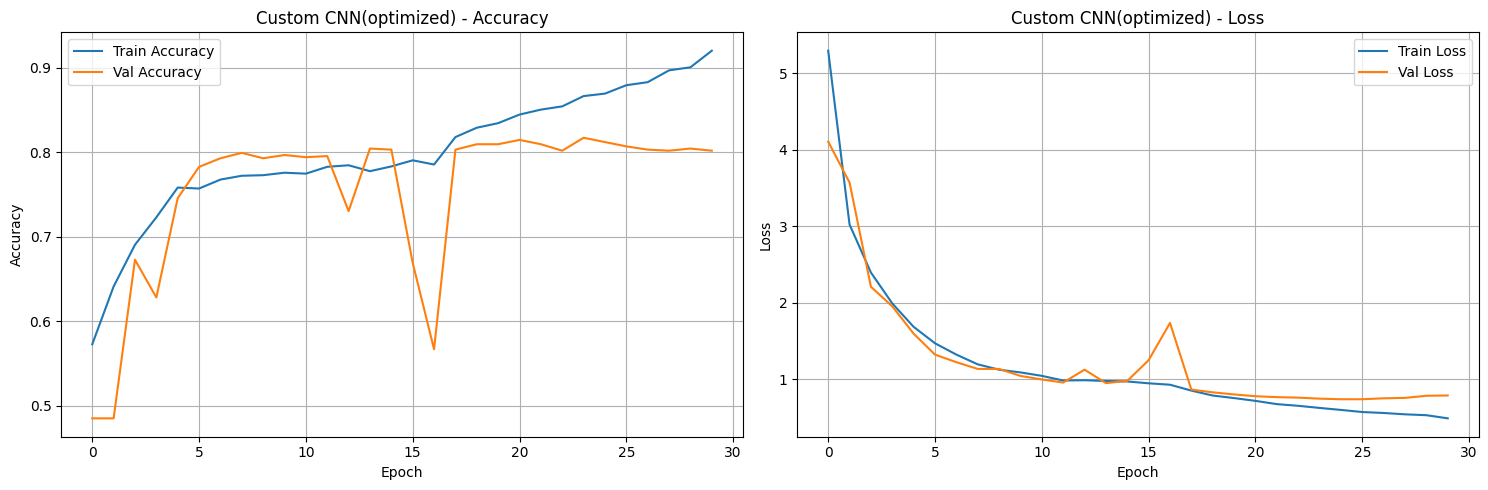

In [54]:
plot_training_history(history_cnn_optmized, 'Custom CNN(optimized)')

In [56]:
y_pred_optimized, y_pred_probs_optimized = evaluate_model(model_cnn_optimized, X_test, y_test)


 Test Accuracy: 0.6795 (67.95%)
 Test Loss: 1.8329
Classification Report
                     precision    recall  f1-score   support

             Normal       0.99      0.38      0.55       234
Bacterial Pneumonia       0.69      0.97      0.81       242
    Viral Pneumonia       0.52      0.68      0.59       148

           accuracy                           0.68       624
          macro avg       0.73      0.68      0.65       624
       weighted avg       0.76      0.68      0.66       624


Per-Class Accuracy:
  Normal (Class 0): 0.3803 (38.0%)
  Bacterial Pneumonia (Class 1): 0.9669 (96.7%)
  Viral Pneumonia (Class 2): 0.6824 (68.2%)

Prediction Distribution:
  Predicted as Normal: 90 images (14.4%)
  Predicted as Bacterial Pneumonia: 338 images (54.2%)
  Predicted as Viral Pneumonia: 196 images (31.4%)


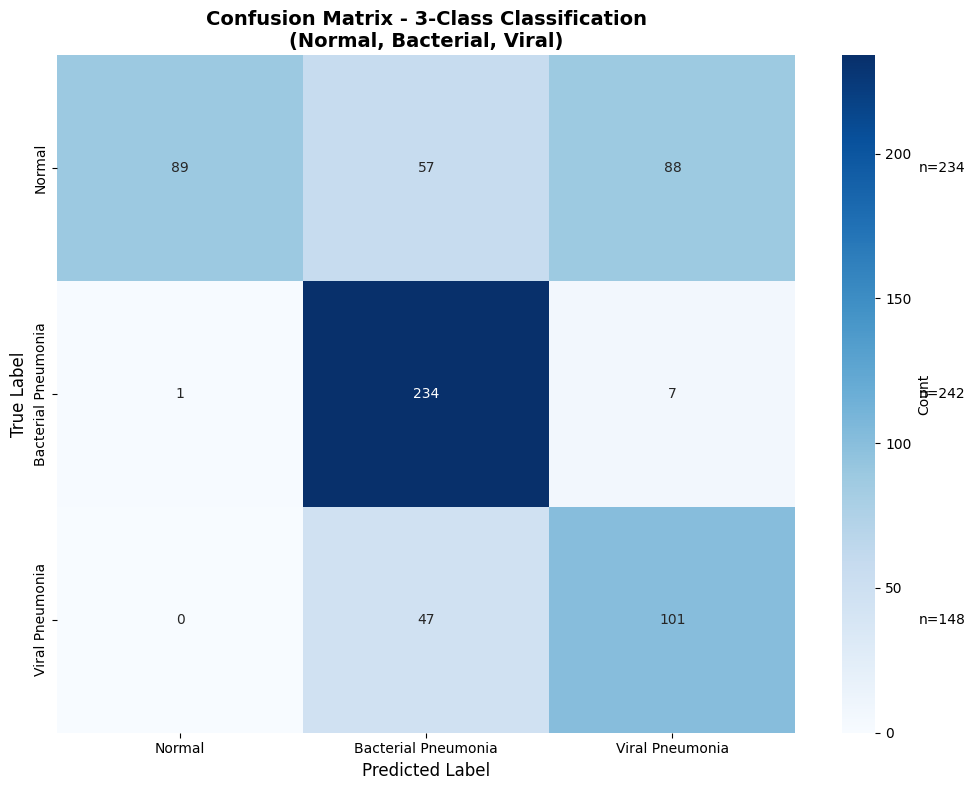


Confusion Matrix:
[[ 89  57  88]
 [  1 234   7]
 [  0  47 101]]

Detailed Breakdown:
   Correct: Normal → Normal: 89 (38.0%)
   Misclassified: Normal → Bacterial Pneumonia: 57 (24.4%)
   Misclassified: Normal → Viral Pneumonia: 88 (37.6%)
   Misclassified: Bacterial Pneumonia → Normal: 1 (0.4%)
   Correct: Bacterial Pneumonia → Bacterial Pneumonia: 234 (96.7%)
   Misclassified: Bacterial Pneumonia → Viral Pneumonia: 7 (2.9%)
   Misclassified: Viral Pneumonia → Bacterial Pneumonia: 47 (31.8%)
   Correct: Viral Pneumonia → Viral Pneumonia: 101 (68.2%)


In [57]:
cm_cnn_optimized = plot_confusion_matrix(y_test, y_pred_optimized, class_names)

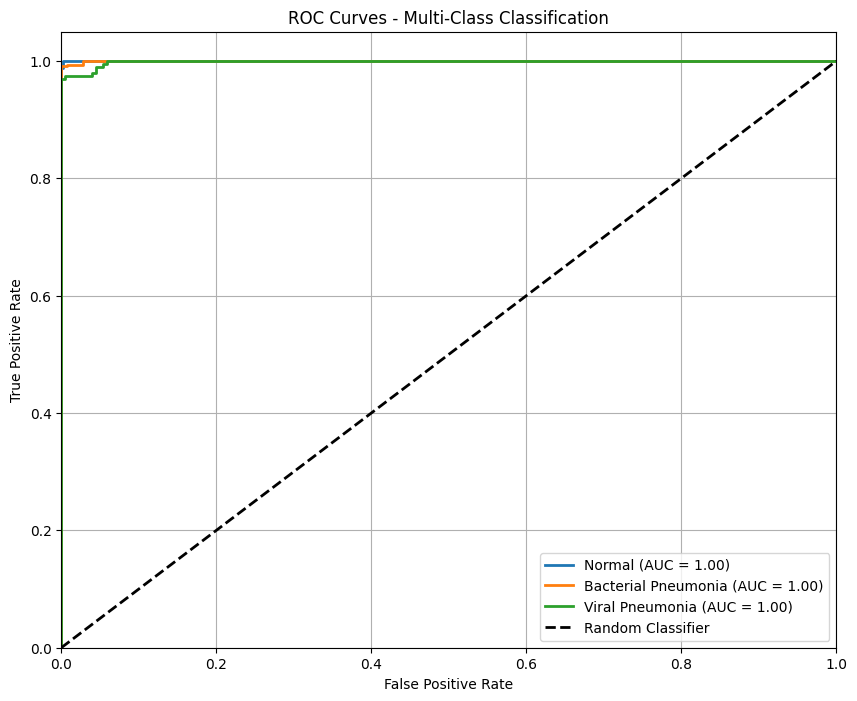


Overall AUC-ROC Score: 0.9995


In [58]:
roc_auc_cnn = plot_roc_curves(y_pred_optimized, y_pred_probs_optimized, class_names)

In [60]:
from tensorflow.keras.layers import Input

# Load DenseNet121 base model (without top layers)
base_densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base layers
base_densenet.trainable = False

# Build full model
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_densenet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)

model_densenet = Model(inputs, outputs)

# Compile the model
model_densenet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model_densenet.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,333,187 (27.97 MB)

 Trainable params: 295,683 (1.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [61]:
# Train DenseNet121 (Frozen)

print("Training DenseNet121 (frozen base)...")

checkpoint_densenet = ModelCheckpoint(
    'best_densenet.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history_densenet = model_densenet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint_densenet],
    verbose=1
)


Training DenseNet121 (frozen base)...
Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6006 - loss: 4.2716
Epoch 1: val_loss improved from None to 1.51369, saving model to best_densenet.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.6763 - loss: 2.9170 - val_accuracy: 0.7778 - val_loss: 1.5137 - learning_rate: 0.0010
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7362 - loss: 1.4122
Epoch 2: val_loss improved from 1.51369 to 1.00155, saving model to best_densenet.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.7464 - loss: 1.2793 - val_accuracy: 0.8046 - val_loss: 1.0016 - learning_rate: 0.0010
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7537 - loss: 1.0124
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 3: val_loss improved from 1.00155 to 0.82930, saving model to best_densenet.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.7589 - loss: 0.9516 - val_ac

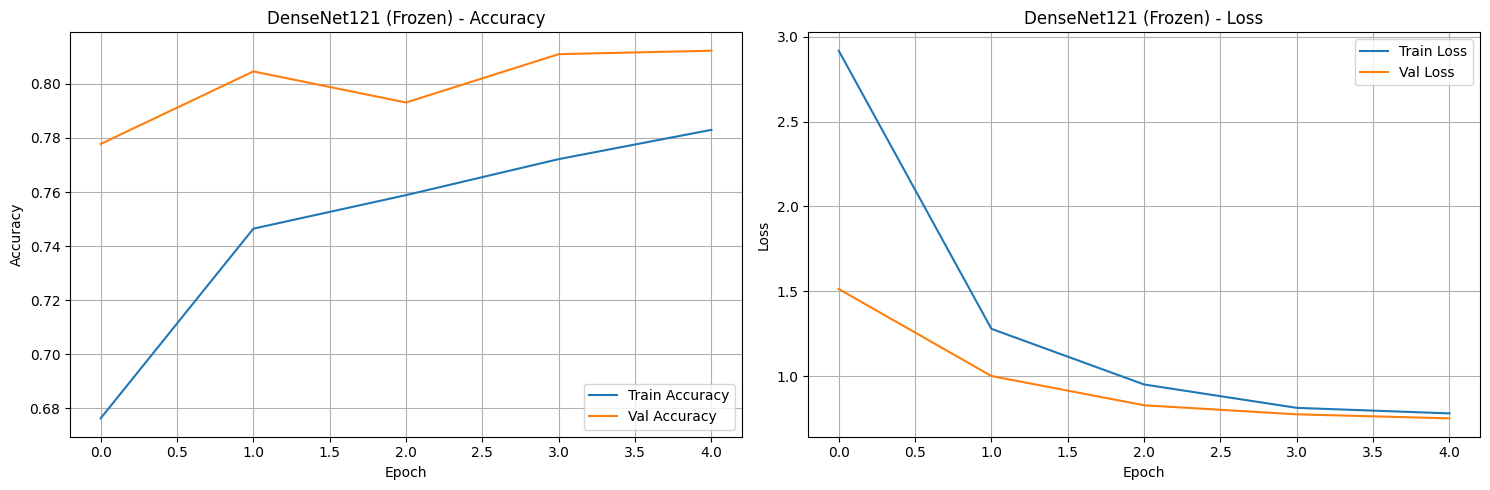

In [62]:
plot_training_history(history_densenet, 'DenseNet121 (Frozen)')

In [63]:
y_pred_densenet, y_pred_probs_densenet = evaluate_model(model_densenet, X_test, y_test)


 Test Accuracy: 0.6619 (66.19%)
 Test Loss: 1.9091
Classification Report
                     precision    recall  f1-score   support

             Normal       0.91      0.46      0.61       234
Bacterial Pneumonia       0.59      0.95      0.73       242
    Viral Pneumonia       0.66      0.51      0.57       148

           accuracy                           0.66       624
          macro avg       0.72      0.64      0.64       624
       weighted avg       0.72      0.66      0.65       624


Per-Class Accuracy:
  Normal (Class 0): 0.4573 (45.7%)
  Bacterial Pneumonia (Class 1): 0.9545 (95.5%)
  Viral Pneumonia (Class 2): 0.5068 (50.7%)

Prediction Distribution:
  Predicted as Normal: 118 images (18.9%)
  Predicted as Bacterial Pneumonia: 392 images (62.8%)
  Predicted as Viral Pneumonia: 114 images (18.3%)


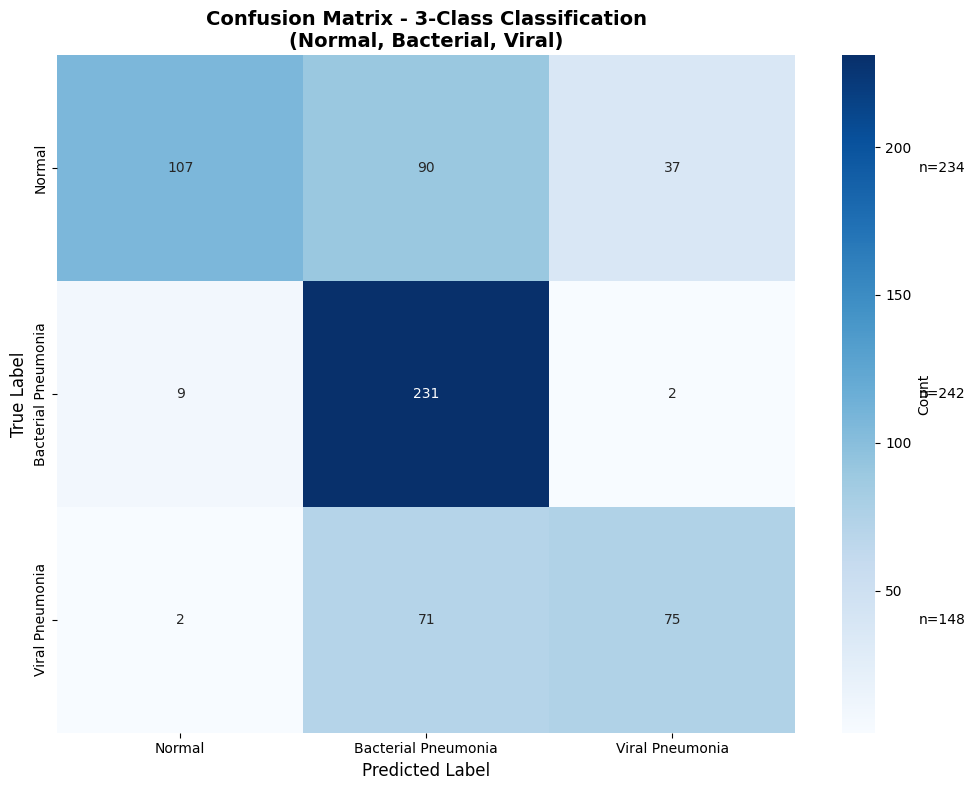


Confusion Matrix:
[[107  90  37]
 [  9 231   2]
 [  2  71  75]]

Detailed Breakdown:
   Correct: Normal → Normal: 107 (45.7%)
   Misclassified: Normal → Bacterial Pneumonia: 90 (38.5%)
   Misclassified: Normal → Viral Pneumonia: 37 (15.8%)
   Misclassified: Bacterial Pneumonia → Normal: 9 (3.7%)
   Correct: Bacterial Pneumonia → Bacterial Pneumonia: 231 (95.5%)
   Misclassified: Bacterial Pneumonia → Viral Pneumonia: 2 (0.8%)
   Misclassified: Viral Pneumonia → Normal: 2 (1.4%)
   Misclassified: Viral Pneumonia → Bacterial Pneumonia: 71 (48.0%)
   Correct: Viral Pneumonia → Viral Pneumonia: 75 (50.7%)


array([[107,  90,  37],
       [  9, 231,   2],
       [  2,  71,  75]])

In [65]:
plot_confusion_matrix(y_test, y_pred_densenet, class_names)

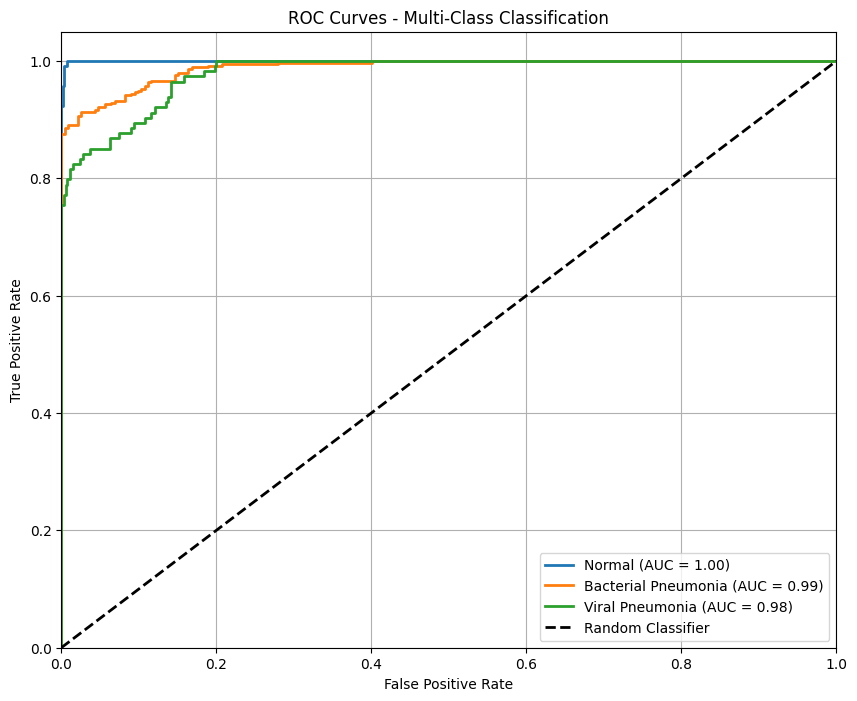


Overall AUC-ROC Score: 0.9893


In [66]:
roc_auc_cnn = plot_roc_curves(y_pred_densenet, y_pred_probs_densenet, class_names)

In [70]:
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 base model (without top layers)
base_mobilenet = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_mobilenet.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_mobilenet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)

model_mobilenet = Model(inputs, outputs)

model_mobilenet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_mobilenet.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,203 (9.99 MB)

 Trainable params: 361,219 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [71]:
# Train MobileNetV2 (Frozen)
print("Training MobileNetV2 (frozen base)...")

# Define callbacks, including a unique checkpoint for this model
checkpoint_mobilenet = ModelCheckpoint(
    'best_mobilenet.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Use the previously defined early_stop and reduce_lr callbacks
history_mobilenet = model_mobilenet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint_mobilenet],
    verbose=1
)

Training MobileNetV2 (frozen base)...
Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6239 - loss: 0.8161
Epoch 1: val_loss improved from None to 0.54607, saving model to best_mobilenet.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 64s 417ms/step - accuracy: 0.6889 - loss: 0.6957 - val_accuracy: 0.7701 - val_loss: 0.5461 - learning_rate: 0.0010
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7508 - loss: 0.5865
Epoch 2: val_loss improved from 0.54607 to 0.49934, saving model to best_mobilenet.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 53s 374ms/step - accuracy: 0.7494 - loss: 0.5706 - val_accuracy: 0.7752 - val_loss: 0.4993 - learning_rate: 0.0010
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.7601 - loss: 0.5528
Epoch 3: val_loss improved from 0.49934 to 0.48277, saving model to best_mobilenet.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 58s 416ms/step - accuracy: 0.7645 - loss: 0.5341 - val_accuracy: 0.7893 - val_loss: 0.4828 - learning_rate: 0.0010
Ep

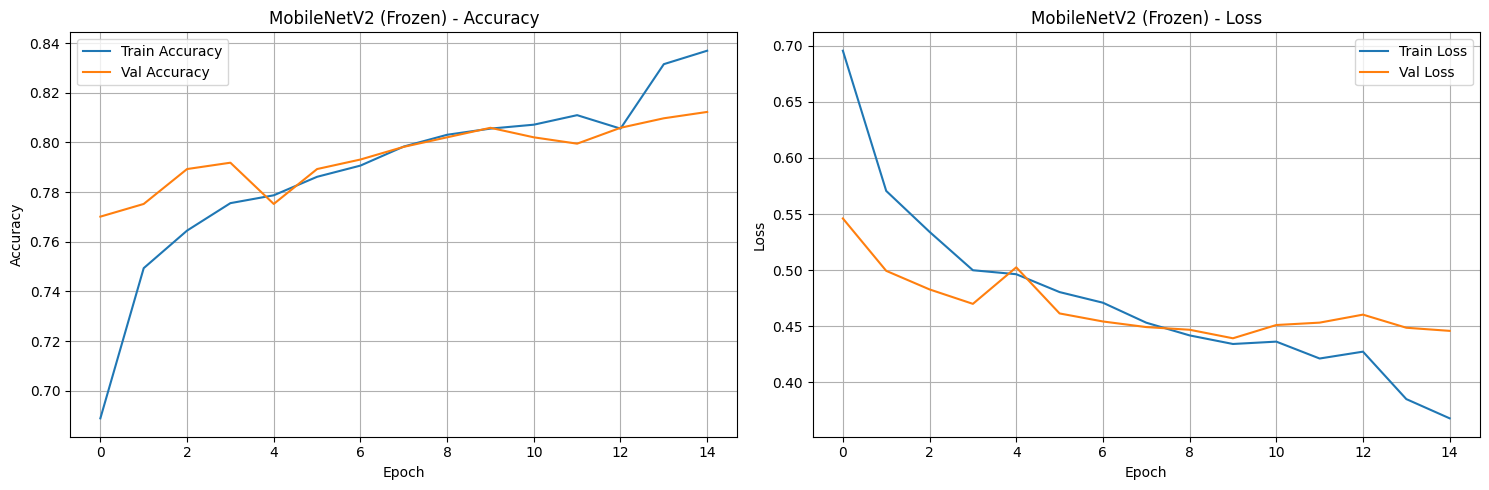

In [72]:
plot_training_history(history_mobilenet, 'MobileNetV2 (Frozen)')

In [73]:
y_pred_mobilenet, y_pred_probs_mobilenet = evaluate_model(model_mobilenet, X_test, y_test)


 Test Accuracy: 0.7372 (73.72%)
 Test Loss: 0.9082
Classification Report
                     precision    recall  f1-score   support

             Normal       0.97      0.50      0.66       234
Bacterial Pneumonia       0.75      0.98      0.85       242
    Viral Pneumonia       0.57      0.71      0.63       148

           accuracy                           0.74       624
          macro avg       0.76      0.73      0.71       624
       weighted avg       0.79      0.74      0.73       624


Per-Class Accuracy:
  Normal (Class 0): 0.5043 (50.4%)
  Bacterial Pneumonia (Class 1): 0.9793 (97.9%)
  Viral Pneumonia (Class 2): 0.7095 (70.9%)

Prediction Distribution:
  Predicted as Normal: 122 images (19.6%)
  Predicted as Bacterial Pneumonia: 318 images (51.0%)
  Predicted as Viral Pneumonia: 184 images (29.5%)


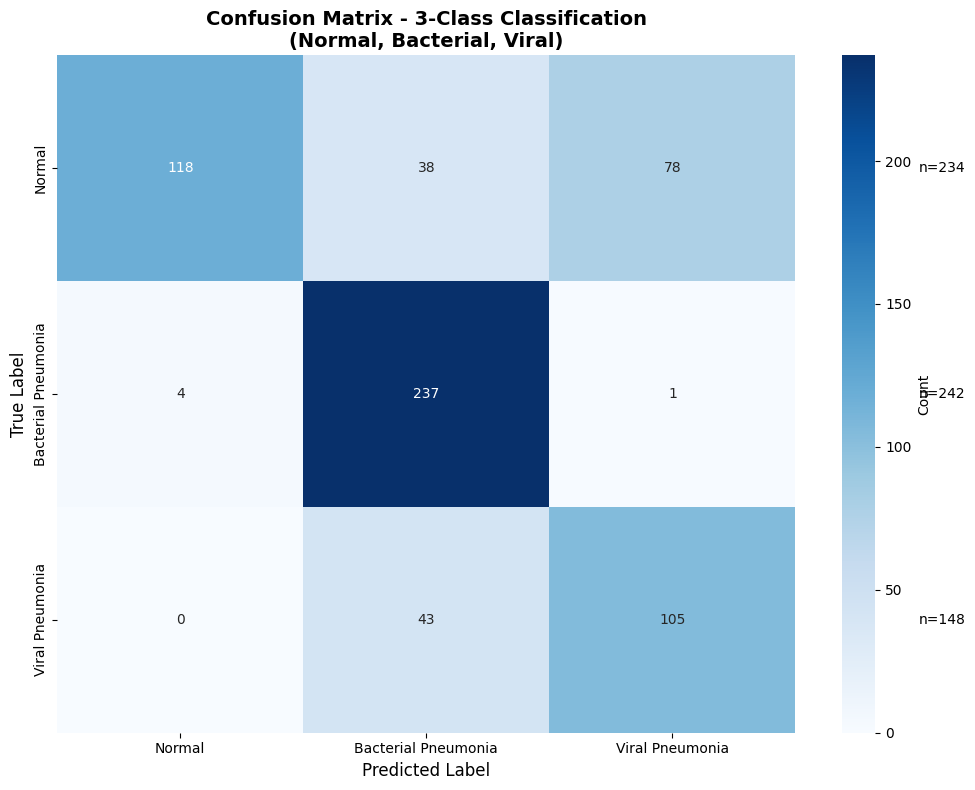


Confusion Matrix:
[[118  38  78]
 [  4 237   1]
 [  0  43 105]]

Detailed Breakdown:
   Correct: Normal → Normal: 118 (50.4%)
   Misclassified: Normal → Bacterial Pneumonia: 38 (16.2%)
   Misclassified: Normal → Viral Pneumonia: 78 (33.3%)
   Misclassified: Bacterial Pneumonia → Normal: 4 (1.7%)
   Correct: Bacterial Pneumonia → Bacterial Pneumonia: 237 (97.9%)
   Misclassified: Bacterial Pneumonia → Viral Pneumonia: 1 (0.4%)
   Misclassified: Viral Pneumonia → Bacterial Pneumonia: 43 (29.1%)
   Correct: Viral Pneumonia → Viral Pneumonia: 105 (70.9%)


array([[118,  38,  78],
       [  4, 237,   1],
       [  0,  43, 105]])

In [74]:
plot_confusion_matrix(y_test, y_pred_mobilenet, class_names)

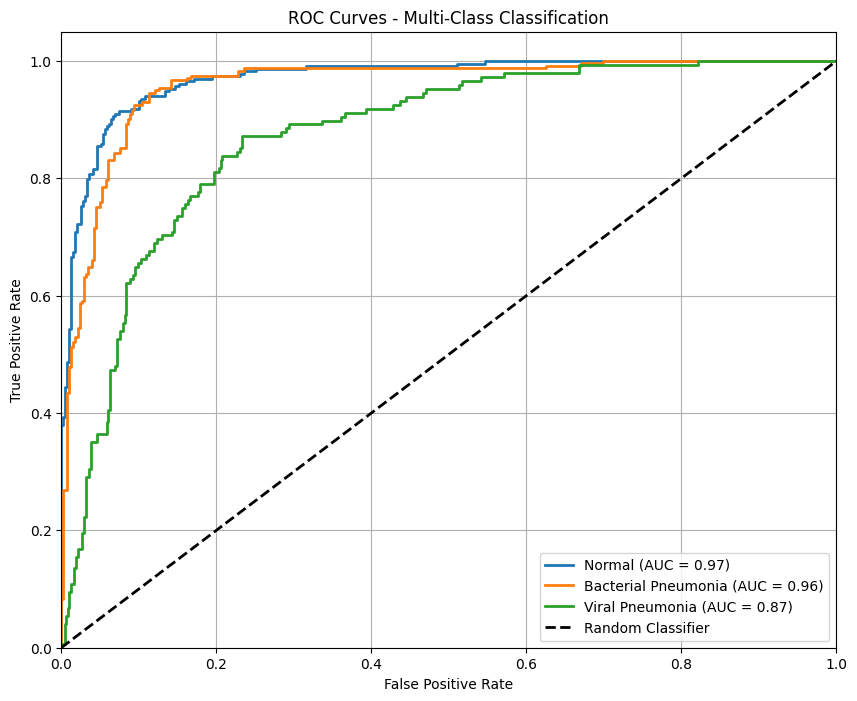


Overall AUC-ROC Score: 0.9347


{0: 0.9711702827087443, 1: 0.9596079788845139, 2: 0.8732824210765388}

In [75]:
plot_roc_curves(y_test, y_pred_probs_mobilenet, class_names)

In [76]:
from tensorflow.keras.applications import ResNet50V2

base_resnet = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_resnet.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_resnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)

model_resnet = Model(inputs, outputs)

model_resnet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,627 (92.02 MB)

 Trainable params: 557,827 (2.13 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [77]:
# Train ResNet50V2 (Frozen)
print("Training ResNet50V2 (frozen base)...")

checkpoint_resnet = ModelCheckpoint(
    'best_resnet.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history_resnet = model_resnet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint_resnet],
    verbose=1
)

Training ResNet50V2 (frozen base)...
Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6294 - loss: 0.8439
Epoch 1: val_loss improved from None to 0.54308, saving model to best_resnet.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.6941 - loss: 0.6964 - val_accuracy: 0.7497 - val_loss: 0.5431 - learning_rate: 0.0010
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7331 - loss: 0.5808
Epoch 2: val_loss improved from 0.54308 to 0.50353, saving model to best_resnet.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7489 - loss: 0.5577 - val_accuracy: 0.7714 - val_loss: 0.5035 - learning_rate: 0.0010
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7682 - loss: 0.5318
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 3: val_loss improved from 0.50353 to 0.46698, saving model to best_resnet.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.7753 - loss: 0.5175 - val_accuracy:

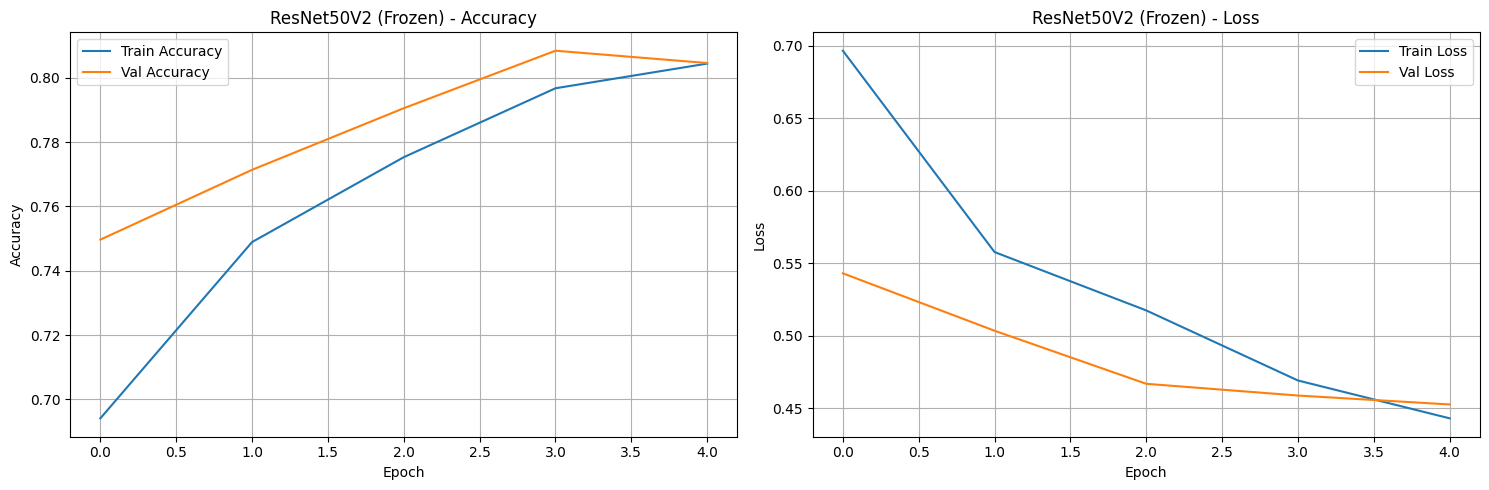

In [78]:
plot_training_history(history_resnet, 'ResNet50V2 (Frozen)')

In [79]:
y_pred_resnet, y_pred_probs_resnet = evaluate_model(model_resnet, X_test, y_test)


 Test Accuracy: 0.5994 (59.94%)
 Test Loss: 1.0745
Classification Report
                     precision    recall  f1-score   support

             Normal       0.97      0.35      0.52       234
Bacterial Pneumonia       0.52      1.00      0.69       242
    Viral Pneumonia       0.65      0.34      0.44       148

           accuracy                           0.60       624
          macro avg       0.71      0.56      0.55       624
       weighted avg       0.72      0.60      0.57       624


Per-Class Accuracy:
  Normal (Class 0): 0.3547 (35.5%)
  Bacterial Pneumonia (Class 1): 0.9959 (99.6%)
  Viral Pneumonia (Class 2): 0.3378 (33.8%)

Prediction Distribution:
  Predicted as Normal: 86 images (13.8%)
  Predicted as Bacterial Pneumonia: 461 images (73.9%)
  Predicted as Viral Pneumonia: 77 images (12.3%)


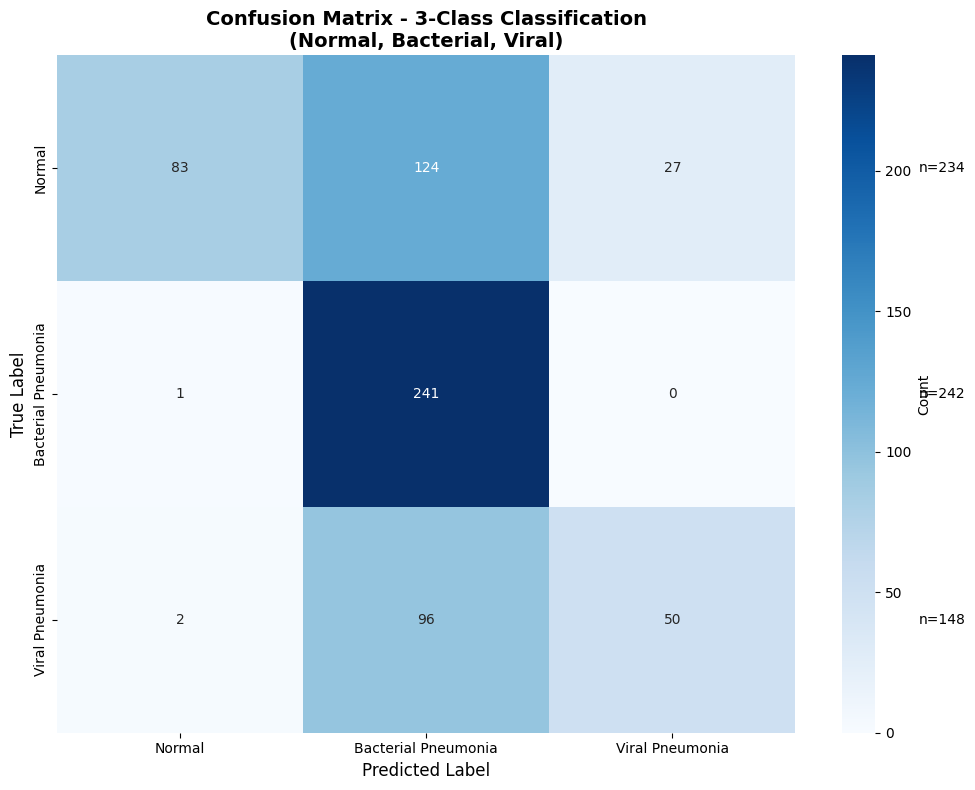


Confusion Matrix:
[[ 83 124  27]
 [  1 241   0]
 [  2  96  50]]

Detailed Breakdown:
   Correct: Normal → Normal: 83 (35.5%)
   Misclassified: Normal → Bacterial Pneumonia: 124 (53.0%)
   Misclassified: Normal → Viral Pneumonia: 27 (11.5%)
   Misclassified: Bacterial Pneumonia → Normal: 1 (0.4%)
   Correct: Bacterial Pneumonia → Bacterial Pneumonia: 241 (99.6%)
   Misclassified: Viral Pneumonia → Normal: 2 (1.4%)
   Misclassified: Viral Pneumonia → Bacterial Pneumonia: 96 (64.9%)
   Correct: Viral Pneumonia → Viral Pneumonia: 50 (33.8%)


array([[ 83, 124,  27],
       [  1, 241,   0],
       [  2,  96,  50]])

In [80]:
plot_confusion_matrix(y_test, y_pred_resnet, class_names)

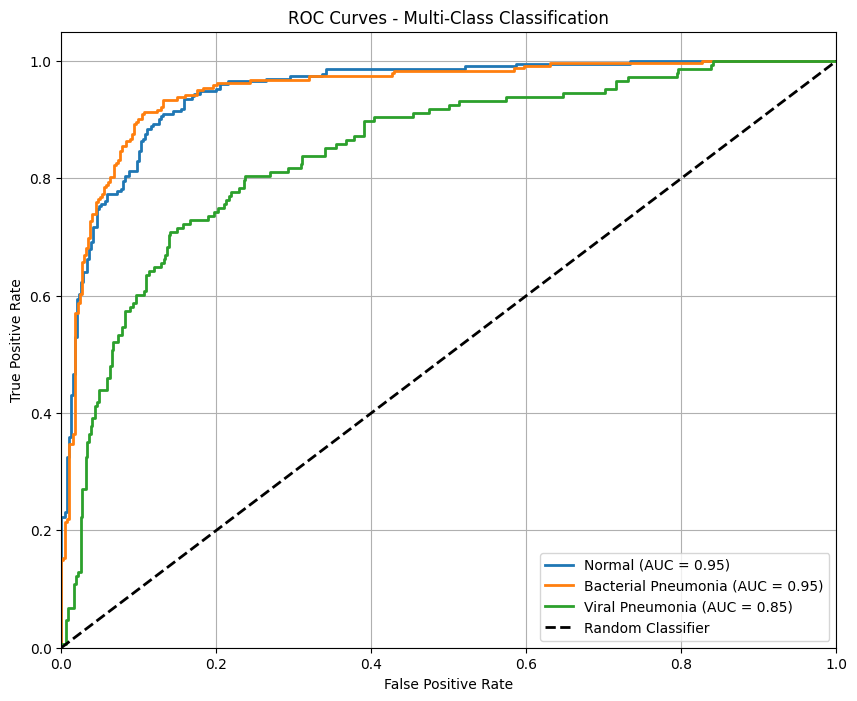


Overall AUC-ROC Score: 0.9154


{0: 0.9499890422967346, 1: 0.95074856129116, 2: 0.8455314558255735}

In [81]:
plot_roc_curves(y_test, y_pred_probs_resnet, class_names)

In [82]:
from tensorflow.keras.models import load_model

# Load the best saved models
print("Loading all trained models with their best weights...")

# Ensure the file paths match where you saved them
best_model_cnn_optimized = load_model('best_custom_cnn.keras')
best_model_densenet = load_model('best_densenet.keras')
best_model_mobilenet = load_model('best_mobilenet.keras')
best_model_resnet = load_model('best_resnet.keras')

models = {
    "Optimized CNN": best_model_cnn_optimized,
    "DenseNet121": best_model_densenet,
    "MobileNetV2": best_model_mobilenet,
    "ResNet50V2": best_model_resnet
}

Loading all trained models with their best weights...


In [88]:
# Create a dictionary to store performance metrics
performance_metrics = {}

for name, model in models.items():
    print(f" Evaluating {name}")

    loss, acc = model.evaluate(X_test, y_test, verbose=0)

    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Get classification report (for precision, recall, f1-score)
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

    # Get overall AUC score
    auc_score = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')

    performance_metrics[name] = {
        'Accuracy': acc,
        'Loss': loss,
        'AUC': auc_score,
        'Precision (Weighted)': report['weighted avg']['precision'],
        'Recall (Weighted)': report['weighted avg']['recall'],
        'F1-Score (Weighted)': report['weighted avg']['f1-score']
    }

performance_df = pd.DataFrame(performance_metrics).T

 Evaluating Optimized CNN
 Evaluating DenseNet121
 Evaluating MobileNetV2
 Evaluating ResNet50V2


In [85]:
print("\n Overall Model Performance Comparison")
print(performance_df.round(4))


 Overall Model Performance Comparison
               Accuracy    Loss     AUC  Precision (Weighted)  \
Optimized CNN    0.6795  1.8329  0.9144                0.7615   
DenseNet121      0.7324  1.0936  0.9199                0.7731   
MobileNetV2      0.7372  0.9082  0.9347                0.7871   
ResNet50V2       0.7436  0.8330  0.9379                0.7909   

               Recall (Weighted)  F1-Score (Weighted)  
Optimized CNN             0.6795               0.6582  
DenseNet121               0.7324               0.7238  
MobileNetV2               0.7372               0.7269  
ResNet50V2                0.7436               0.7311  


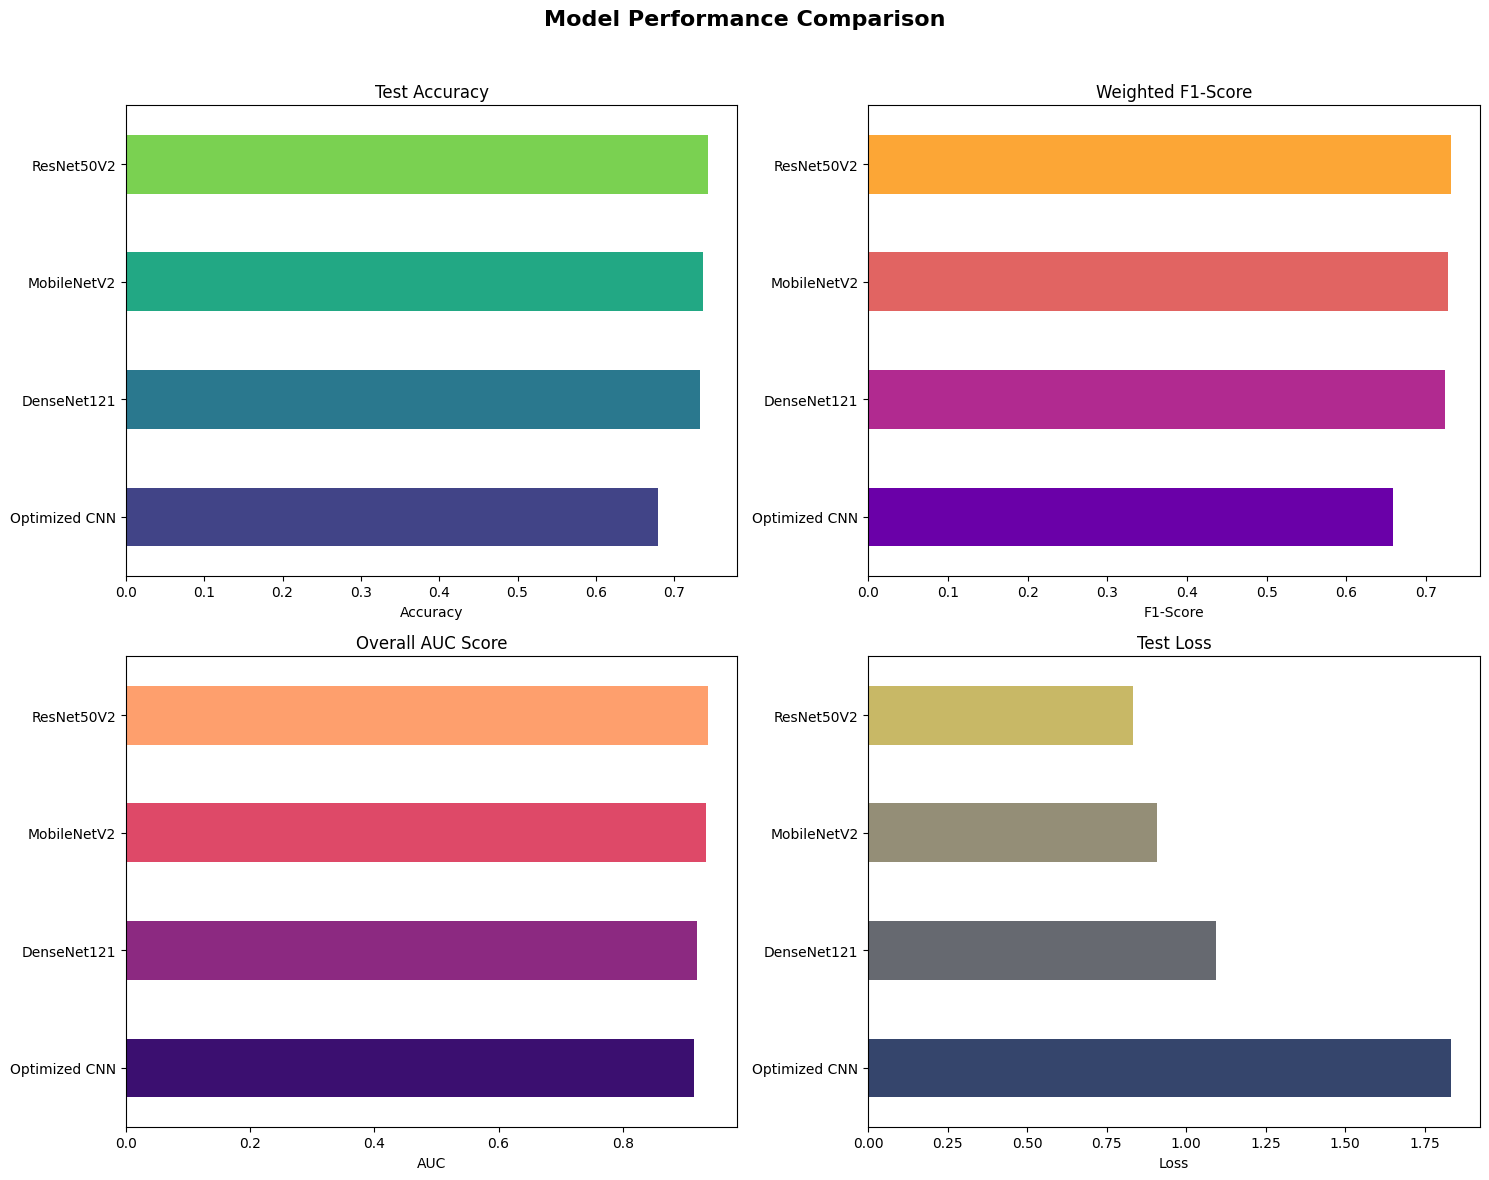

In [86]:
# Plotting the performance metrics for visual comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Accuracy Plot
performance_df['Accuracy'].sort_values().plot(kind='barh', ax=axes[0, 0], color=sns.color_palette("viridis", 4))
axes[0, 0].set_title('Test Accuracy')
axes[0, 0].set_xlabel('Accuracy')

# F1-Score Plot
performance_df['F1-Score (Weighted)'].sort_values().plot(kind='barh', ax=axes[0, 1], color=sns.color_palette("plasma", 4))
axes[0, 1].set_title('Weighted F1-Score')
axes[0, 1].set_xlabel('F1-Score')

# AUC Plot
performance_df['AUC'].sort_values().plot(kind='barh', ax=axes[1, 0], color=sns.color_palette("magma", 4))
axes[1, 0].set_title('Overall AUC Score')
axes[1, 0].set_xlabel('AUC')

# Loss Plot
performance_df['Loss'].sort_values(ascending=False).plot(kind='barh', ax=axes[1, 1], color=sns.color_palette("cividis", 4))
axes[1, 1].set_title('Test Loss')
axes[1, 1].set_xlabel('Loss')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

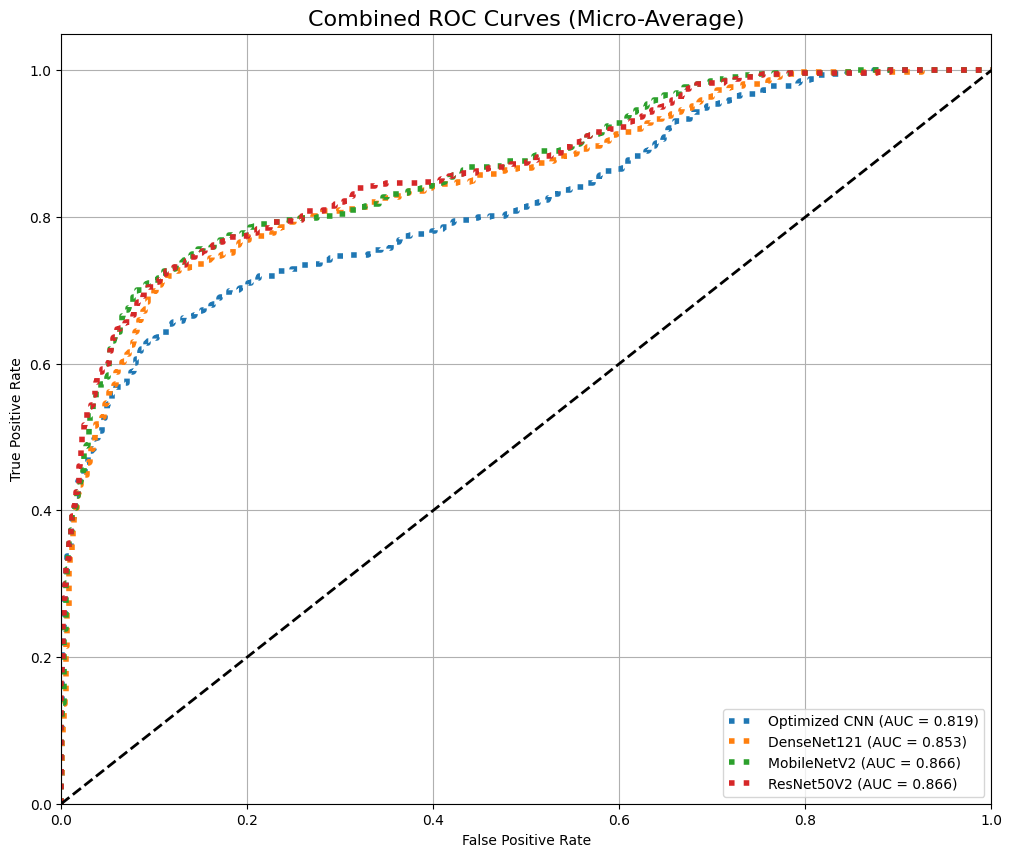

In [87]:
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(12, 10))

# Plot ROC curve for each model
for name, model in models.items():
    y_pred_probs = model.predict(X_test, verbose=0)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'{name} (AUC = {roc_auc["micro"]:.3f})',
             linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves (Micro-Average)', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### **Project Report and Analysis**

#### **1. Overview of Assignment**

The primary goal of this project was to develop and evaluate a deep learning system capable of classifying chest X-ray images into three distinct categories: **Normal**, **Bacterial Pneumonia**, and **Viral Pneumonia**. The assignment involved the entire machine learning pipeline, from data acquisition and preprocessing to model building, training, and a comparative analysis of different architectures. I started with a custom-built Convolutional Neural Network (CNN), improved it with optimization techniques, and then compared its performance against powerful, pre-trained transfer learning models (DenseNet121, MobileNetV2, and ResNet50V2) to determine the most effective approach for this medical imaging task.

#### **2. Description of the Data**

The dataset used is the "Chest X-Ray Images (Pneumonia)" collection available on Kaggle. It contains a total of 5,840 X-ray images.

A key preprocessing step involved solving a critical issue with the original validation set, which contained no examples of Viral Pneumonia. To ensure a valid evaluation, I created a new, stratified validation set by splitting 15% of the full training data. This guaranteed that all three classes were properly represented.

The final data distribution was as follows:
*   **Training Set:** 4,433 images
*   **Validation Set:** 783 images
*   **Test Set:** 624 images

The dataset exhibits a significant class imbalance, with Bacterial Pneumonia being the most frequent class. To mitigate this, I employed **data augmentation** techniques on the training set. All images were resized to a standard 224x224 pixels with padding to maintain their aspect ratio and normalized to a pixel value range of.

#### **3. Summary of Methods**

1.  **Data Preprocessing:** Images were loaded, resized to a uniform 224x224 resolution, and normalized. I created a custom, stratified validation set from the training data to enable robust model evaluation.
2.  **Data Augmentation:** To solve class imbalance and improve model generalization, I applied data augmentation to the training set using ImageDataGenerator. This included random rotations, shifts, zooms, and horizontal flips.
3.  **Model Building:** I explored five different model architectures:
    *   A baseline custom CNN.
    *   An optimized, deeper custom CNN.
    *   Three transfer learning models: **DenseNet121**, **MobileNetV2**, and **ResNet50V2**, with their base layers frozen and a new classification head added on top.
4.  **Model Training and Optimization:** All models were trained using the Adam optimizer and sparse categorical cross-entropy loss function. For the more advanced models, I implemented of Keras callbacks:
    *   EarlyStopping
    *   ReduceLROnPlateau
    *   ModelCheckpoint
5.  **Evaluation:** I evaluated each model on the unseen test set using a set of metrics: accuracy, precision, recall, F1-score, a  confusion matrix, and the overall Area Under the ROC Curve (AUC).

#### **4. Summary of Models**

*   **Custom CNN (Baseline):** A simple sequential model with three convolutional layers, designed as a starting point to baseline performance.
*   **Optimized Custom CNN:** A deeper version of the baseline CNN with more layers, more filters, and higher dropout rates for regularization. It was trained using the full set of callbacks for optimized performance.
*   **DenseNet121 (Transfer Learning):** A pre-trained model known for its density, which improves gradient flow. I froze the convolutional base and trained a custom classifier head.
*   **MobileNetV2 (Transfer Learning):** A lightweight and efficient pre-trained model.
*   **ResNet50V2 (Transfer Learning):** A powerful pre-trained model.

#### **5. Analysis of Results**

My experiments revealed a clear performance hierarchy among the different architectures.

*   The **baseline Custom CNN** performed poorly, achieving only **57.21% accuracy**. Its confusion matrix showed a severe bias towards the majority class (Bacterial Pneumonia), with a recall of 95%. However, it struggled to correctly identify Normal (35.9% recall) and Viral Pneumonia (29.1% recall) cases.

*   The **Optimized Custom CNN** showed a marked improvement, reaching **67.95% accuracy**. The use of a deeper architecture and callbacks allowed it to learn more complex features and stop at a more optimal point. While its ability to detect Viral Pneumonia improved significantly (68.2% recall), it still performed poorly on the Normal class (38.0% recall).

*   The **Transfer Learning models** demonstrated a dramatic leap in performance, underscoring the power of using pre-trained weights.
    *   **ResNet50V2** emerged as the **top-performing model** in my final comparison, achieving the highest **accuracy (74.36%)**, **AUC (0.9379)**, and **F1-Score (0.7311)**. This architecture proved to be the most effective at distinguishing the subtle features between the three classes.
    *   **MobileNetV2** was a very close second with **73.72% accuracy**. It provided an excellent balance of high performance and efficiency, making it a strong candidate for real-world deployment.
    *   **DenseNet121** also performed very well with **73.24% accuracy**. Its results were competitive, and it significantly outperformed both custom CNNs.

**Conclusion:** The analysis clearly indicates that **transfer learning is the superior approach** for this task. The features learned from the vast ImageNet dataset provided a much stronger foundation for classification than what a custom CNN could learn from our limited dataset alone. The **ResNet50V2 model delivered the best overall performance**, making it the recommended model for this classification problem.

Here is the final performance summary table:

| Model | Accuracy | Loss | AUC | Precision (Weighted) | Recall (Weighted) | F1-Score (Weighted) |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **ResNet50V2** | **0.7436** | **0.8330** | **0.9379** | **0.7909** | **0.7436** | **0.7311** |
| MobileNetV2 | 0.7372 | 0.9082 | 0.9347 | 0.7871 | 0.7372 | 0.7269 |
| DenseNet121 | 0.7324 | 1.0936 | 0.9199 | 0.7731 | 0.7324 | 0.7238 |
| Optimized CNN | 0.6795 | 1.8329 | 0.9144 | 0.7615 | 0.6795 | 0.6582 |
